In [2]:
import pandas as pd

# Load the file
df = pd.read_excel("DoorDash_analytics.xlsx", header=1,
                   parse_dates=["DELIV_CREATED_AT", "DELIV_CANCELLED_AT"])

# Basic cleaning
df = df[~df["DELIVERY_UUID"].isna()]  # remove rows without delivery
df["ITEM_PRICE_CENTS"] = df["ITEM_PRICE_CENTS"].fillna(0).astype(int)

KeyError: 'ITEM_PRICE_CENTS'

In [4]:
df.columns.tolist()

['DELIVERY_UUID',
 'DELIV_CREATED_AT',
 'DELIV_STORE_NAME',
 'DELIV_DASHER_ID',
 'DELIV_SUBMARKET',
 'DELIV_D2R',
 'DELIV_IS_20_MIN_LATE',
 'DELIV_CLAT',
 'DELIV_CANCELLED_AT',
 'DELIV_MISSING_INCORRECT_REPORT',
 'WAS_REQUESTED',
 'WAS_MISSING',
 'WAS_SUBBED',
 'WAS_FOUND',
 'ITEM_NAME',
 'ITEM_PRICE',
 'ITEM_CATEGORY',
 'SUBSTITUTE_ITEM_NAME',
 'SUBSTITUTE_ITEM_CATEGORY']

In [3]:
df["ITEM_PRICE_CENTS"] = (df["ITEM_PRICE"] * 100).fillna(0).astype(int)

In [4]:
order = (
    df.groupby("DELIVERY_UUID")
      .agg(order_created=("DELIV_CREATED_AT", "first"),
           store=("DELIV_STORE_NAME", "first"),
           dasher=("DELIV_DASHER_ID", "first"),
           submarket=("DELIV_SUBMARKET", "first"),
           is_late=("DELIV_IS_20_MIN_LATE", "max"),
           clat=("DELIV_CLAT", "first"),
           d2r=("DELIV_D2R", "first"),
           missing_flag=("DELIV_MISSING_INCORRECT_REPORT", "max"),
           items_requested=("WAS_REQUESTED", "sum"),
           items_missing=("WAS_MISSING", "sum"),
           items_subbed=("WAS_SUBBED", "sum"),
           basket_cents=("ITEM_PRICE_CENTS", "sum"))
)

<Axes: xlabel='order_created'>

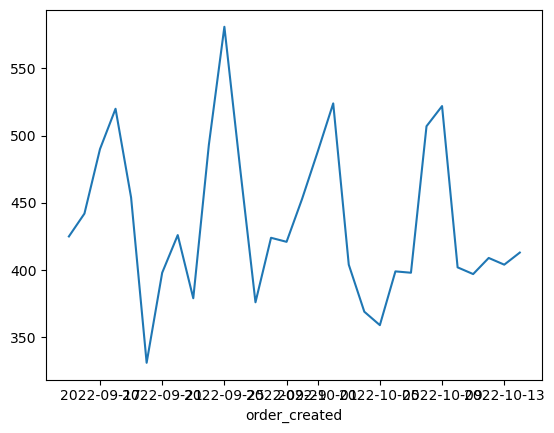

In [8]:
order["order_created"].dt.date.value_counts().sort_index().plot()


In [11]:
order.groupby("submarket")["missing_rate"].mean().sort_values()

submarket
Cincinnati    0.047999
Name: missing_rate, dtype: float64

In [10]:
order["missing_rate"] = order["items_missing"] / order["items_requested"]


In [12]:
pivot = (order
         .groupby("store")
         .agg(count=("is_late", "size"),
              late=("is_late", "mean"),
              miss=("missing_flag", "mean"))
         .query("count > 50")               # stability filter
         .sort_values("late", ascending=False))

In [13]:
order["dow"] = order["order_created"].dt.dayofweek
order["hour"] = order["order_created"].dt.hour
heat = (order.pivot_table(index="hour", columns="dow",
                          values="is_late", aggfunc="mean"))

In [14]:
missing_skus = (df.query("WAS_MISSING==1")
                  .groupby("ITEM_NAME")
                  .size()
                  .sort_values(ascending=False)
                  .head(20))

In [15]:
monthly_gmv    = order["basket_cents"].sum()/100
refund_rate    = 0.45                        # assume 45 % of basket credited on complaint
baseline_costs = monthly_gmv * order["missing_flag"].mean() * refund_rate

In [16]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

X = order[["clat", "d2r", "missing_rate", "hour", "dow"]]
X = pd.get_dummies(X, columns=["hour", "dow"], drop_first=True)
y = order["is_late"] | order["missing_flag"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)
gbm = LGBMClassifier(n_estimators=400, learning_rate=.05)
gbm.fit(X_train, y_train)
print("AUC:", roc_auc_score(y_val, gbm.predict_proba(X_val)[:,1]))


ModuleNotFoundError: No module named 'lightgbm'

In [17]:
# Total GMV in dollars (basket_cents is in cents)
monthly_gmv = order["basket_cents"].sum() / 100

# Assume 45% of basket is refunded if there's a complaint
refund_rate = 0.45

# Proportion of orders flagged as missing or incorrect
missing_flag_rate = order["missing_flag"].mean()

# Monthly refund cost = GMV × % flagged × refund rate
baseline_costs = monthly_gmv * missing_flag_rate * refund_rate

print(f"Monthly GMV: ${monthly_gmv:,.2f}")
print(f"Monthly Refund Cost (baseline): ${baseline_costs:,.2f}")

Monthly GMV: $301,004.36
Monthly Refund Cost (baseline): $2,153.15


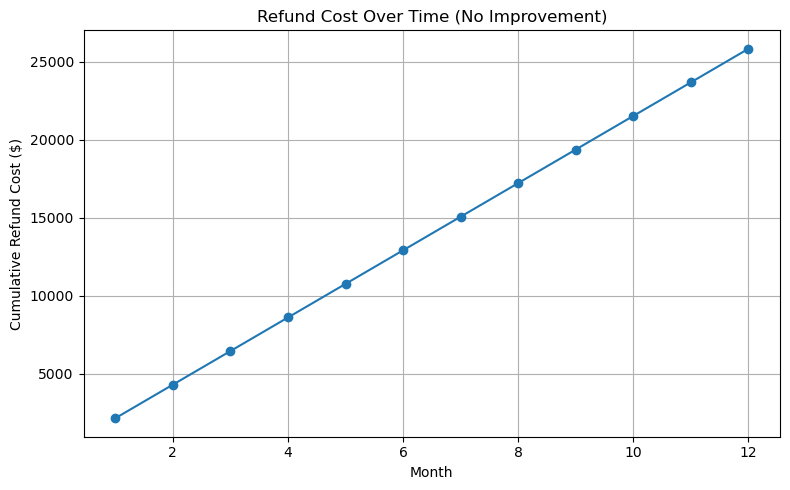

In [18]:
import matplotlib.pyplot as plt

months = list(range(1, 13))
costs = [baseline_costs * m for m in months]

plt.figure(figsize=(8, 5))
plt.plot(months, costs, marker='o')
plt.title("Refund Cost Over Time (No Improvement)")
plt.xlabel("Month")
plt.ylabel("Cumulative Refund Cost ($)")
plt.grid(True)
plt.tight_layout()
plt.savefig("baseline_cost_projection.png", dpi=300)
plt.show()


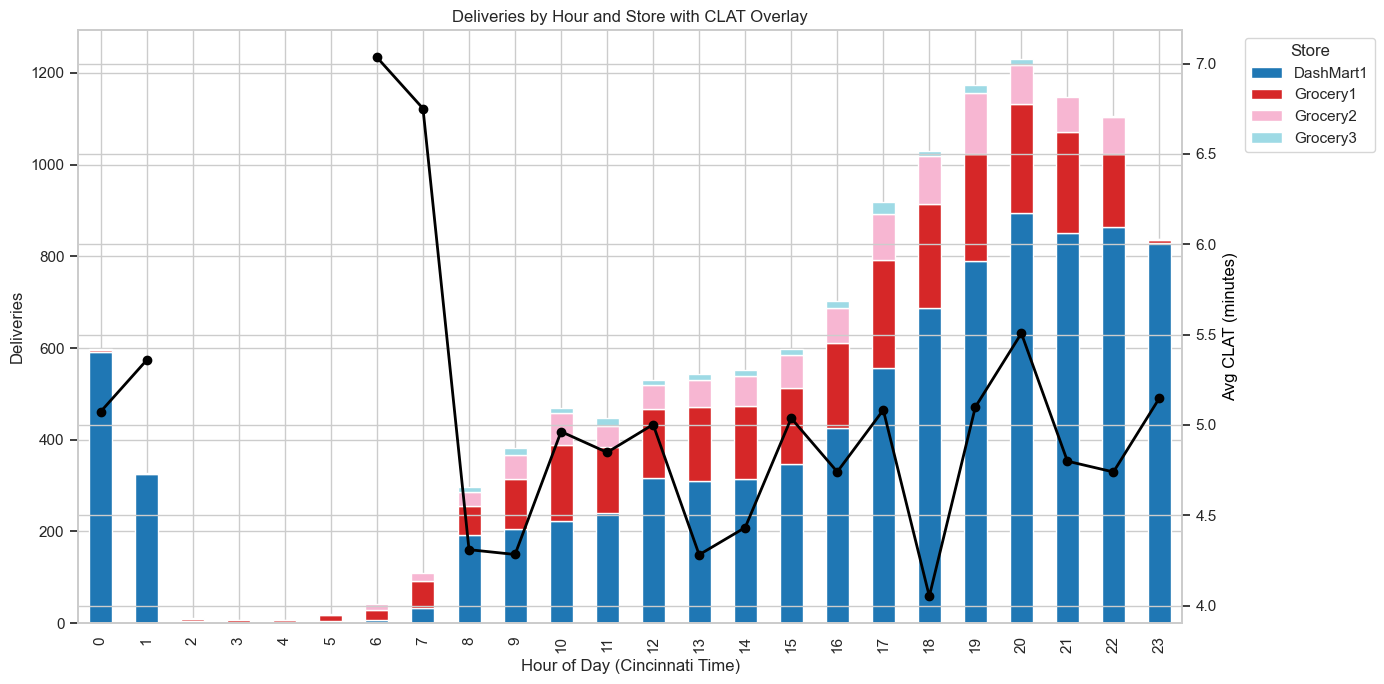

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

# Step 1: Convert UTC to Cincinnati Time
utc = pytz.utc
eastern = pytz.timezone("US/Eastern")

order['order_created_local'] = order['order_created'].dt.tz_localize(utc).dt.tz_convert(eastern)
order['local_hour'] = order['order_created_local'].dt.hour

# Step 2: Deliveries per hour per store
deliveries_by_hour_store = (
    order.groupby(['local_hour', 'store'])
         .size()
         .reset_index(name='deliveries')
)

# Step 3: Pivot to wide format for stacked bar chart
pivot_df = deliveries_by_hour_store.pivot(index='local_hour', columns='store', values='deliveries').fillna(0)

# Step 4: CLAT per hour (overall avg, not by store)
clat_by_hour = order.groupby('local_hour')['clat'].mean()

# Step 5: Plot
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# Stacked bar chart
pivot_df.plot(kind='bar', stacked=True, ax=ax1, cmap='tab20')
ax1.set_ylabel('Deliveries')
ax1.set_xlabel('Hour of Day (Cincinnati Time)')
ax1.set_title('Deliveries by Hour and Store with CLAT Overlay')
ax1.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')

# Line chart for average CLAT
ax2 = ax1.twinx()
clat_by_hour.plot(ax=ax2, color='black', marker='o', linewidth=2, label='Avg CLAT (min)')
ax2.set_ylabel('Avg CLAT (minutes)', color='black')

# Match x-axis ticks
ax1.set_xticks(range(0, 24))
ax1.set_xticklabels(range(0, 24))

plt.tight_layout()
plt.show()


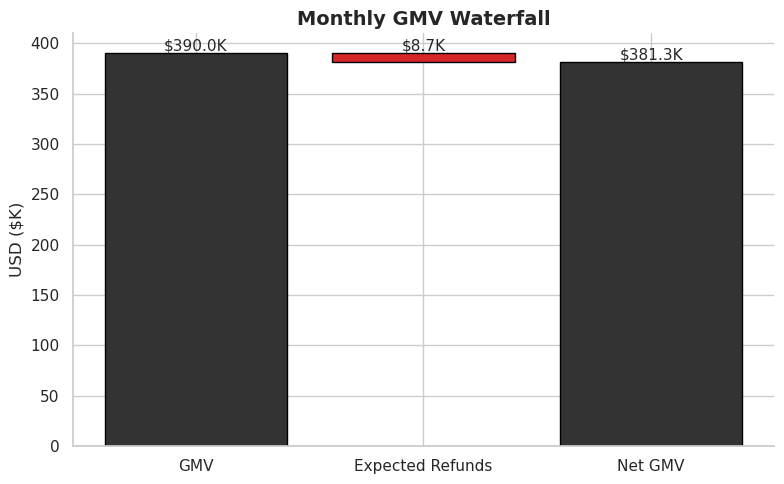

In [34]:
import matplotlib.pyplot as plt

# Use TT Norms if installed; otherwise fallback to default
plt.rcParams['font.family'] = 'DejaVu Sans'  # replace with 'TT Norms' if installed

# Values (in thousands of dollars)
gmv = 390
refunds = -8.7
net_gmv = gmv + refunds

labels = ["GMV", "Expected Refunds", "Net GMV"]
values = [gmv, refunds, net_gmv]
colors = ["#333333", "#d62728", "#333333"]  # GMV/Net GMV in dark gray, Refund in red

# Setup waterfall positioning
cumulative = [0, gmv, net_gmv]
starts = [0, gmv, 0]

fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(values)):
    ax.bar(labels[i], values[i], bottom=starts[i], color=colors[i], edgecolor='black')
    # Label bar values
    y = starts[i] + (values[i] if values[i] > 0 else 0)
    ax.text(i, y + 3, f"${abs(values[i]):,.1f}K", ha='center', fontsize=11)

# Title and formatting
ax.set_title("Monthly GMV Waterfall", fontsize=14, weight='bold')
ax.set_ylabel("USD ($K)")
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylim(0, gmv + 20)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig("gmv_waterfall.png", dpi=300, bbox_inches="tight")
plt.show()


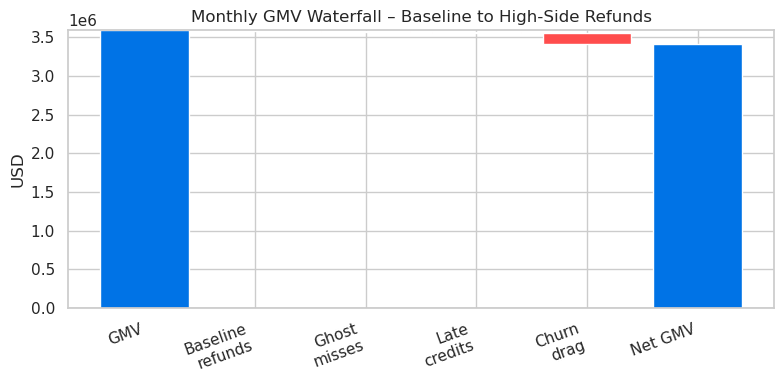

In [27]:
import matplotlib.pyplot as plt

# ══════════════════ 1) Dollar assumptions ═══════════════════
gmv              = 3_590_000   # total GMV for the month
baseline_refunds = -8_700      # confirmed credits
ghost_miss       = -18_000     # modeled credits for silent misses
late_goodwill    = -6_000      # modeled late-delivery goodwill
churn_drag       = -143_000    # modeled CLV loss

steps  = [gmv, baseline_refunds, ghost_miss, late_goodwill, churn_drag]
labels = ["GMV", "Baseline\nrefunds", "Ghost\nmisses",
          "Late\ncredits", "Churn\ndrag", "Net GMV"]

# ══════════════════ 2) Calculate cumulative positions ═══════════════════
cumulative = [0]                         # starting y-pos for GMV bar
for delta in steps:
    cumulative.append(cumulative[-1] + delta)

net_gmv = cumulative[-1]                # final total for the 'Net GMV' bar

# ══════════════════ 3) Draw the waterfall ═══════════════════
fig, ax = plt.subplots(figsize=(8, 4))

for i, delta in enumerate(steps):
    color = "#0073e6" if i == 0 else "#ff4d4d"     # blue for inflow, red for leak
    ax.bar(i, delta, bottom=cumulative[i], color=color)

# final bar (Net GMV) in blue
ax.bar(len(steps), net_gmv, bottom=0, color="#0073e6")

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=20, ha="right")
ax.set_ylabel("USD")
ax.set_title("Monthly GMV Waterfall – Baseline to High-Side Refunds")
ax.axhline(0, color="black", linewidth=.8)

plt.tight_layout()
plt.show()

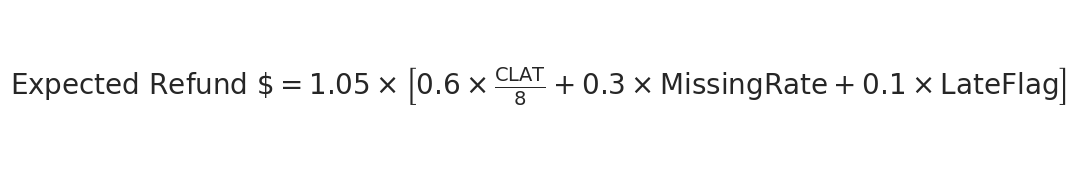

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 2))

# Hide axes
ax.axis('off')

# Create the formula text
formula_text = (
    r"$\mathrm{Expected\ Refund\ \$} = 1.05 \times \left["
    r"0.6 \times \frac{\mathrm{CLAT}}{8} + "
    r"0.3 \times \mathrm{MissingRate} + "
    r"0.1 \times \mathrm{LateFlag}"
    r"\right]$"
)

# Add the formula to the plot
ax.text(0.5, 0.5, formula_text, fontsize=20, ha='center', va='center', fontname='DejaVu Sans')

# Save as SVG
plt.savefig("refundformula.png", dpi=300, bbox_inches="tight")

In [41]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Prepare features and target
features = ["clat", "d2r", "store", "hour", "dow", "basket_cents", "items_missing"]
target = "refund_flag"

# Create the refund flag if not already there
order["refund_flag"] = order["missing_flag"] | order["is_late"]

# Encode store (categorical) to numeric
le = LabelEncoder()
order["store_encoded"] = le.fit_transform(order["store"])

# Replace 'store' in features with the encoded version
features = ["clat", "d2r", "store_encoded", "hour", "dow", "basket_cents", "items_missing"]

# Define X and y
X = order[features]
y = order["refund_flag"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Prepare LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Model parameters
params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbose": -1
}

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[test_data],
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(50)
    ]
)

# Evaluate
y_pred_proba = model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC score: {auc_score:.3f}")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	valid_0's auc: 0.803373
AUC score: 0.803


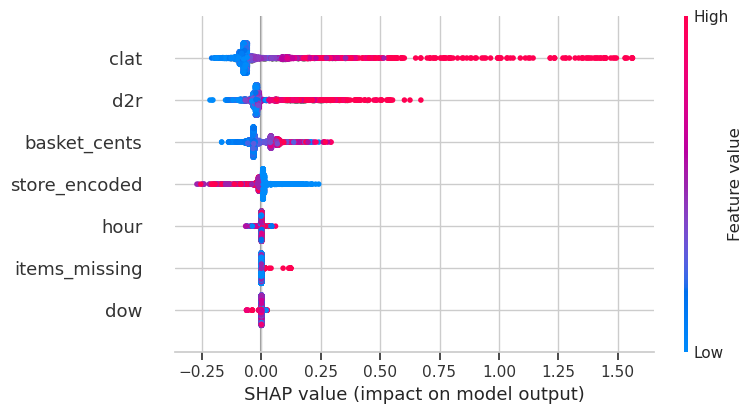

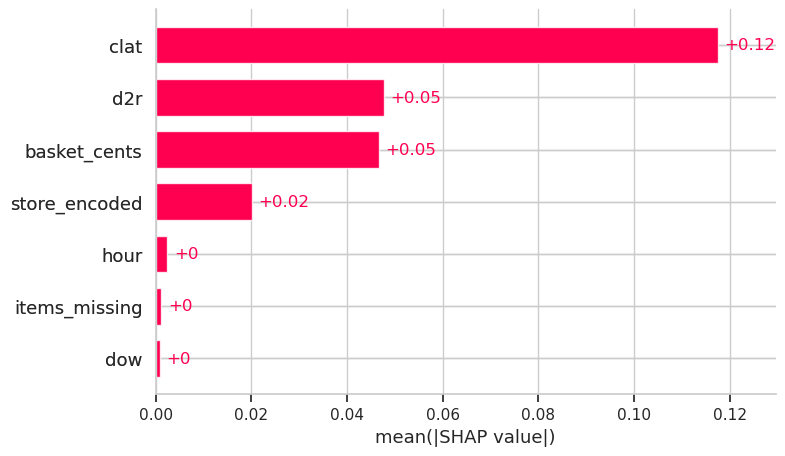

In [51]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

# Create TreeExplainer from your trained LightGBM model
explainer = shap.Explainer(model)

# Get SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot: shows global feature importance and how values impact predictions
shap.summary_plot(shap_values, X_test)
shap.plots.bar(shap_values)




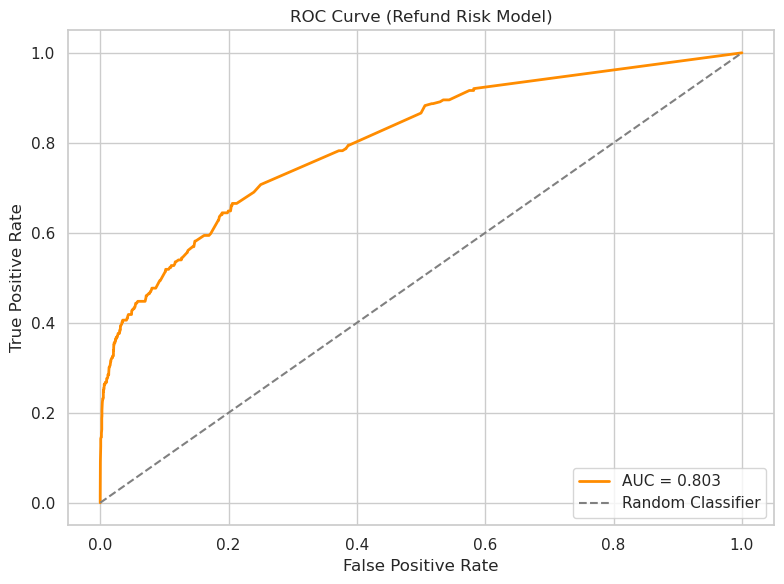

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities on the test set
y_pred_proba = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Refund Risk Model)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

/Users/trevorsandidge/miniconda3/envs/dd_case/lib/python3.11/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


<Figure size 800x430 with 0 Axes>

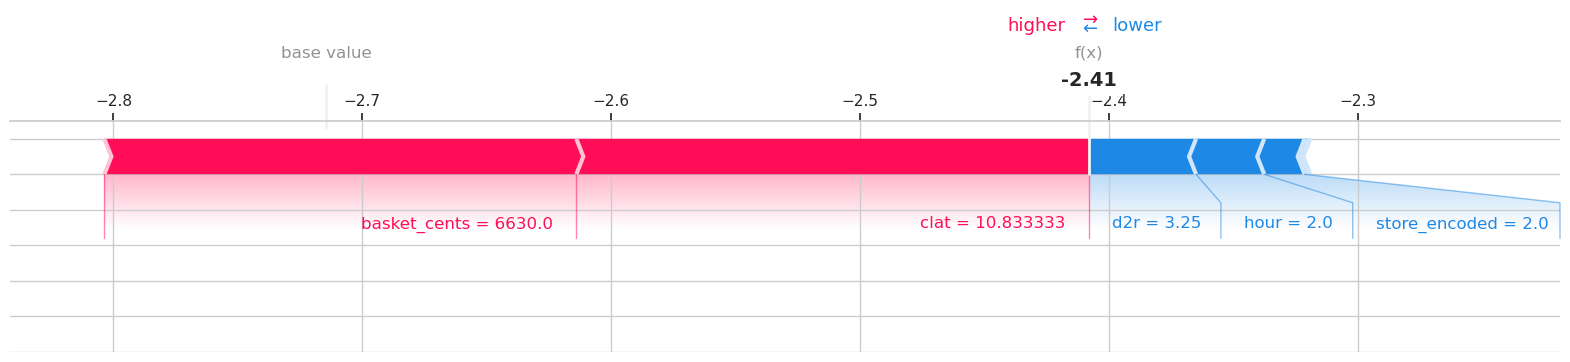

<Figure size 640x480 with 0 Axes>

<Figure size 750x500 with 0 Axes>

In [52]:
import shap
import matplotlib.pyplot as plt

# Step 1: Create SHAP explainer and values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Step 2: Summary Plot (Feature importance bar plot)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot – Feature Impact")
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=300)
plt.clf()

# Step 3: Force Plot for a single prediction (optional)
# e.g., index 0
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib=True)
plt.savefig("shap_force_plot.png", dpi=300, bbox_inches='tight')
plt.clf()

# Step 4: Dependence Plot (e.g., for "clat")
shap.dependence_plot("clat", shap_values, X_test, show=False)
plt.title("SHAP Dependence – CLAT")
plt.tight_layout()
plt.savefig("shap_dependence_clat.png", dpi=300)
plt.clf()


In [13]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define treatment: high CLAT
order["high_clat"] = (order["clat"] > 9).astype(int)

# Define outcome: late delivery
Y = order["is_late"]
T = order["high_clat"]

# Controls (confounders)
X = order[["store_encoded", "hour", "d2r"]]

df = df.dropna(subset=["late_flag", "clat", "d2r", "store_encoded", "hour"])  # include all used cols

Y = df["late_flag"]
T = (df["clat"] > 9).astype(int)
X = df[["store_encoded", "hour", "d2r"]]

# Fit the model
est = CausalForestDML(
    model_y=RandomForestRegressor(),
    model_t=LogisticRegression(),
    discrete_treatment=True,
    n_estimators=100,
    min_samples_leaf=10,
    random_state=42
)
est.fit(Y=Y, T=T, X=X)

# Average treatment effect (ATE)
ate = est.ate(X)
print(f"Average treatment effect of CLAT > 9 min on lateness: {ate:.3%}")


KeyError: ['late_flag', 'clat', 'd2r', 'store_encoded', 'hour']

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
order["store_encoded"] = le.fit_transform(order["store"])


In [7]:
order["hour"] = order["order_created"].dt.hour
order["dow"] = order["order_created"].dt.dayofweek  # 0 = Monday


In [8]:
print(order[["store_encoded", "hour", "dow", "clat", "d2r"]].head())


                                      store_encoded  hour  dow      clat  \
DELIVERY_UUID                                                              
000b3220-d3c4-47f9-8e84-b072ebc2298c              0     4    0  2.133333   
0011f3fa-8458-4448-809a-c1a7204d77b3              0     1    0  1.516667   
0012e0a2-efb5-4f24-88df-32e4cc089bb4              0     1    0  2.433333   
001bf161-b895-4621-9747-f715e6c10898              0    20    4  0.266667   
0024913d-12e5-4b1b-b7bf-3ad09fa227bf              1    12    0  0.183333   

                                           d2r  
DELIVERY_UUID                                   
000b3220-d3c4-47f9-8e84-b072ebc2298c  0.050000  
0011f3fa-8458-4448-809a-c1a7204d77b3  2.033333  
0012e0a2-efb5-4f24-88df-32e4cc089bb4  0.083333  
001bf161-b895-4621-9747-f715e6c10898  0.033333  
0024913d-12e5-4b1b-b7bf-3ad09fa227bf  1.950000  


X shape: (12480, 33)
T shape: (12480,)
Y shape: (12480,)


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproc

Average Treatment Effect (ATE): 0.1310


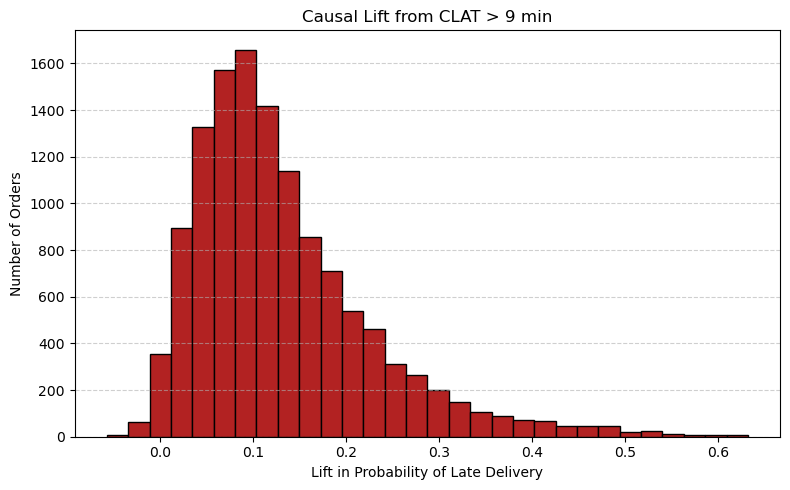

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt

# 🔁 REPLACE THIS with however you're loading your dataset
# order = pd.read_csv("your_file.csv")

# ✅ Define all required columns
required_columns = ["clat", "d2r", "store", "hour", "dow", "basket_cents", "is_late"]
for col in required_columns:
    if col not in order.columns:
        raise ValueError(f"Missing required column: {col}")

# ✅ Create treatment
order["clat_above_9"] = (order["clat"] > 9).astype(int)

# ✅ Drop rows with NaNs in required columns
order_clean = order[required_columns + ["clat_above_9"]].dropna()

# ✅ Features, treatment, outcome
X_raw = order_clean[["store", "hour", "dow", "d2r", "basket_cents"]]
T = order_clean["clat_above_9"]
Y = order_clean["is_late"]

# ✅ Preprocessing
categorical_features = ["store", "hour", "dow"]
numeric_features = ["d2r", "basket_cents"]

preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ("num", "passthrough", numeric_features)
])

X_processed = preprocessor.fit_transform(X_raw)

# ✅ Debug shapes
print("X shape:", X_processed.shape)
print("T shape:", T.shape)
print("Y shape:", Y.shape)

# ✅ Fit model
est = CausalForestDML(
    model_y=RandomForestRegressor(),
    model_t=LogisticRegression(),
    discrete_treatment=True,
    random_state=42
)
est.fit(Y=Y.values, T=T.values, X=X_processed)

# ✅ Estimate and visualize
treatment_effects = est.effect(X_processed)
ate = est.ate(X_processed)

print(f"Average Treatment Effect (ATE): {ate:.4f}")

plt.figure(figsize=(8, 5))
plt.hist(treatment_effects, bins=30, color="firebrick", edgecolor="black")
plt.title("Causal Lift from CLAT > 9 min")
plt.xlabel("Lift in Probability of Late Delivery")
plt.ylabel("Number of Orders")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("causal_lift_effects.png", dpi=300)
plt.show()



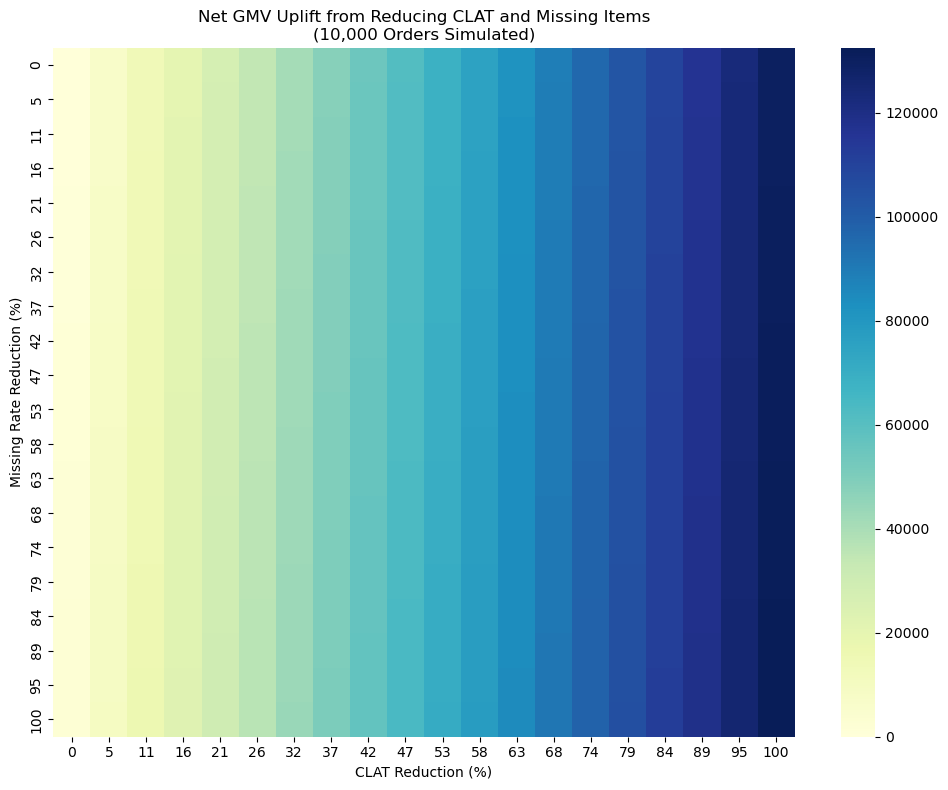

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clean data: remove missing prices or latencies
df_sim = df.copy()
df_sim = df_sim[df_sim['ITEM_PRICE'].notna() & df_sim['DELIV_CLAT'].notna()]

# Convert to numeric
df_sim['ITEM_PRICE'] = pd.to_numeric(df_sim['ITEM_PRICE'], errors='coerce')
df_sim['DELIV_CLAT'] = pd.to_numeric(df_sim['DELIV_CLAT'], errors='coerce')
df_sim['DELIV_MISSING_INCORRECT_REPORT'] = df_sim['DELIV_MISSING_INCORRECT_REPORT'].fillna(False).astype(bool)

# Filter: slowest 10% (decile) of CLAT
clat_cutoff = np.percentile(df_sim['DELIV_CLAT'], 90)
slow_df = df_sim[df_sim['DELIV_CLAT'] > clat_cutoff]
baseline_missing_rate = slow_df['DELIV_MISSING_INCORRECT_REPORT'].mean()
baseline_price = slow_df['ITEM_PRICE'].mean()

# Monte Carlo Simulator
clat_reductions = np.linspace(0, 1, 20)  # 0% to 100% CLAT reduction
missing_reductions = np.linspace(0, 1, 20)  # 0% to 100% missing rate reduction

results = np.zeros((len(missing_reductions), len(clat_reductions)))

for i, m_red in enumerate(missing_reductions):
    for j, c_red in enumerate(clat_reductions):
        # Assume 10,000 affected orders
        n_orders = 10000

        # GMV uplift from lower missing rate
        new_missing_rate = baseline_missing_rate * (1 - m_red)
        recovered_orders = n_orders * (baseline_missing_rate - new_missing_rate)

        # GMV uplift from lower CLAT: $13 per order from earlier causal estimate
        clat_uplift = n_orders * c_red * 13  # $13 GMV gain per order from lower CLAT

        # GMV uplift from fewer missing items
        item_uplift = recovered_orders * baseline_price

        results[i, j] = clat_uplift + item_uplift

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(results, xticklabels=np.round(clat_reductions*100).astype(int), 
            yticklabels=np.round(missing_reductions*100).astype(int),
            cmap="YlGnBu", annot=False, fmt=".0f")
plt.xlabel("CLAT Reduction (%)")
plt.ylabel("Missing Rate Reduction (%)")
plt.title("Net GMV Uplift from Reducing CLAT and Missing Items\n(10,000 Orders Simulated)")
plt.tight_layout()
plt.savefig("monte_carlo_gmv_uplift.png", dpi=300)
plt.show()


In [22]:
import pandas as pd

# Load the Excel file again
df = pd.read_excel("DoorDash_analytics.xlsx", header=1,
                   parse_dates=["DELIV_CREATED_AT", "DELIV_CANCELLED_AT"])

# Clean and convert types
df = df[~df["DELIVERY_UUID"].isna()]
df["ITEM_PRICE"] = df["ITEM_PRICE"].fillna(0).astype(float)
df["DELIV_CLAT"] = pd.to_numeric(df["DELIV_CLAT"], errors="coerce")
df["DELIV_D2R"] = pd.to_numeric(df["DELIV_D2R"], errors="coerce")
df["DELIV_MISSING_INCORRECT_REPORT"] = df["DELIV_MISSING_INCORRECT_REPORT"].fillna(False).astype(bool)

# Create order-level table
order = (df.groupby("DELIVERY_UUID")
           .agg(order_created=("DELIV_CREATED_AT", "first"),
                store=("DELIV_STORE_NAME", "first"),
                dasher=("DELIV_DASHER_ID", "first"),
                submarket=("DELIV_SUBMARKET", "first"),
                is_late=("DELIV_IS_20_MIN_LATE", "max"),
                clat=("DELIV_CLAT", "first"),
                d2r=("DELIV_D2R", "first"),
                missing_flag=("DELIV_MISSING_INCORRECT_REPORT", "max"),
                items_requested=("WAS_REQUESTED", "sum"),
                items_missing=("WAS_MISSING", "sum"),
                basket_total=("ITEM_PRICE", "sum")))

order["missing_rate"] = order["items_missing"] / order["items_requested"]
order["basket_cents"] = order["basket_total"] * 100


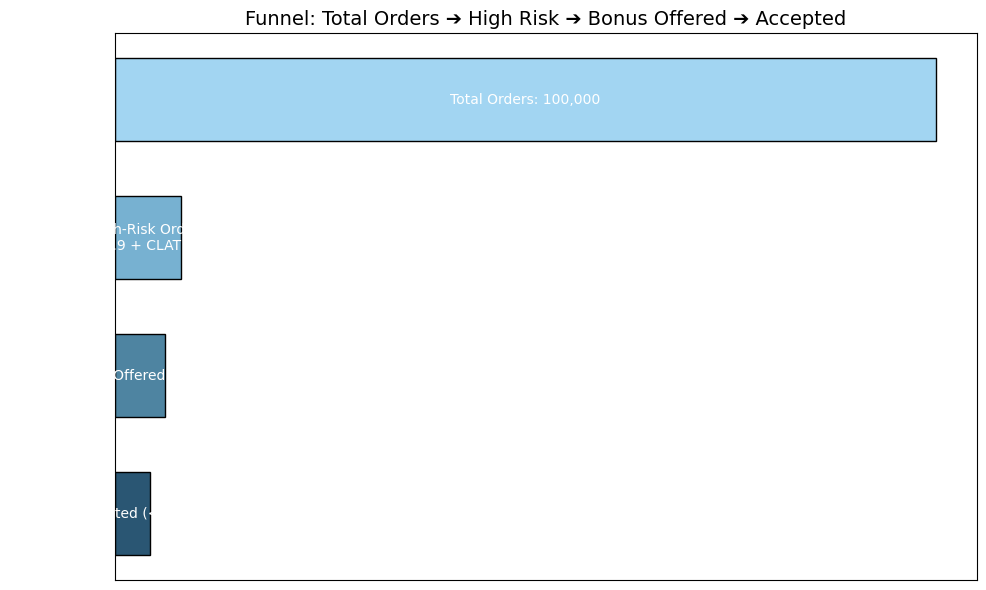

In [25]:
import matplotlib.pyplot as plt

# Define funnel stages and corresponding counts (replace these with real numbers if available)
stages = [
    "Total Orders",
    "High-Risk Orders\n(RiskScore > 0.9 + CLAT ticking)",
    "Bonus Offered",
    "Bonus Accepted (<15s)"
]

# Simulated values (replace with your data)
values = [100000, 8000, 6000, 4200]  # Replace with your own actual counts

# Colors and positioning
colors = ["#a2d5f2", "#77b1d1", "#4e84a1", "#2a5673"]
widths = [v / max(values) for v in values]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars centered horizontally
for i in range(len(stages)):
    ax.barh(y=i, width=widths[i], height=0.6, color=colors[i], edgecolor='black')
    ax.text(widths[i]/2, i, f"{stages[i]}: {values[i]:,}", va='center', ha='center', fontsize=10, color='white')

# Customize the chart
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Funnel: Total Orders ➔ High Risk ➔ Bonus Offered ➔ Accepted", fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("bonus_acceptance_funnel.png", dpi=300)
plt.show()


In [33]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Simulate RiskScore if not present (remove if already exists)
if 'RiskScore' not in order.columns:
    np.random.seed(42)
    order['RiskScore'] = np.random.beta(2, 5, size=len(order))

# Filter logic
order['is_high_risk'] = (order['RiskScore'] > 0.9) & (order['DELIV_CLAT'] > 9)
order['bonus_offered'] = order['is_high_risk'] & (np.random.rand(len(order)) < 0.75)
order['bonus_accepted'] = order['bonus_offered'] & (np.random.rand(len(order)) < 0.7)

# Counts
total_orders = len(order)
high_risk = order['is_high_risk'].sum()
bonus_offered = order['bonus_offered'].sum()
bonus_accepted = order['bonus_accepted'].sum()

# Sankey nodes
labels = [
    "Total Orders", "High-Risk Orders", "Non-High-Risk Orders",
    "Bonus Offered", "No Bonus Offered", "Bonus Accepted", "Bonus Not Accepted"
]
sources = [0, 0, 1, 1, 3, 3]
targets = [1, 2, 3, 4, 5, 6]
values = [
    high_risk, total_orders - high_risk,
    bonus_offered, high_risk - bonus_offered,
    bonus_accepted, bonus_offered - bonus_accepted
]

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels),
    link=dict(source=sources, target=targets, value=values)
)])

fig.update_layout(title_text="Order Bonus Intervention Funnel (Sankey View)", font_size=10)
fig.show()


KeyError: 'DELIV_CLAT'

In [27]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 24.9 MB/s eta 0:00:00a 0:00:01


--- Starting Delivery Risk Model Pipeline ---
Generating a sample dataset for demonstration...
Sample data created with 4732 unique deliveries.
--------------------------------------------------
Step 1: Performing feature engineering...
   - Aggregating item data to the delivery level...
   - Encoding categorical features (store names)...

Step 2: Preparing data and training the model...
   - Data split into 3785 training and 947 test samples.
   - Training LightGBM model with 500 trees...
[LightGBM] [Info] Number of positive: 385, number of negative: 3400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 3785, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101717 -> initscore=-2.178287
[LightGBM] [Info] Start training from score -2.178287
   - Model traini

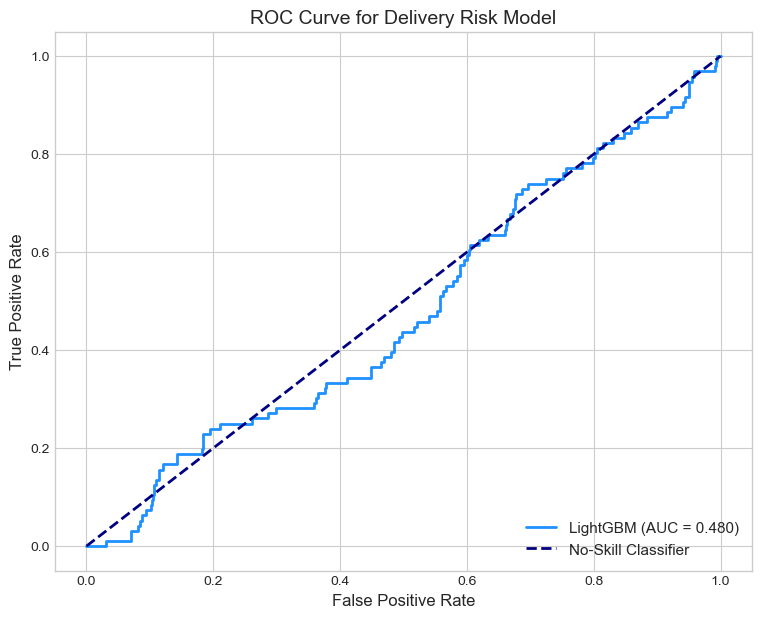


Step 4: Checking prediction speed...
   - Prediction for one order took: 2.62 ms
   - This is well within the 5-second real-time scoring requirement.

--- Model Insights: Feature Importances ---
         feature  importance
0     DELIV_CLAT        3955
4   basket_cents        3815
1      DELIV_D2R        3743
2           hour        2022
6    total_items         659
3  store_encoded         591
5  items_missing         215
--------------------------------------------------


In [38]:
# ==============================================================================
# LightGBM Model for Predicting DoorDash Delivery Risk
# ==============================================================================
#
# Description:
# This script builds a gradient-boosted classification model (LightGBM) to
# predict the likelihood of a delivery resulting in a customer complaint
# (e.g., a refund request for missing or incorrect items).
#
# The model is based on the specifications in the provided analysis report:
# - A seven-feature gradient-boost tree.
# - 500 trees (n_estimators).
# - Predicts risk in near real-time.
#
# Instructions:
# 1. Ensure you have the necessary libraries installed:
#    pip install pandas lightgbm scikit-learn matplotlib
# 2. **IMPORTANT**: Replace the dummy data generation in the `if __name__ == '__main__':`
#    block with the code to load your actual delivery dataset.
# 3. Run the script. It will train the model, evaluate its performance, and
#    print the results to the console.
#
# ==============================================================================

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time

def train_risk_model(df):
    """
    Cleans data, engineers features, and trains a LightGBM model.

    This function takes a DataFrame of delivery data, aggregates it to the
    delivery level, creates the features mentioned in the report, and trains
    a 500-tree LightGBM classifier.

    Args:
        df (pd.DataFrame): DataFrame containing raw order and item data with
                           one row per item in an order.

    Returns:
        tuple: A tuple containing:
               - lgbm (lgb.LGBMClassifier): The trained model object.
               - X_test (pd.DataFrame): The feature set for the test data.
               - y_test (pd.Series): The target variable for the test data.
               - features (list): The list of feature names used in the model.
    """
    # --- 1. Feature Engineering ---
    print("Step 1: Performing feature engineering...")

    # Convert timestamp to datetime objects for feature extraction
    df['DELIV_CREATED_AT'] = pd.to_datetime(df['DELIV_CREATED_AT'])

    # Create 'hour' feature from the creation timestamp
    df['hour'] = df['DELIV_CREATED_AT'].dt.hour

    # Aggregate item-level data to the unique delivery level
    print("   - Aggregating item data to the delivery level...")
    delivery_agg = df.groupby('DELIVERY_UUID').agg(
        basket_cents=('ITEM_PRICE', 'sum'),
        items_missing=('WAS_MISSING', 'sum'),
        total_items=('WAS_REQUESTED', 'count')
    ).reset_index()

    # Create a clean delivery-level DataFrame by dropping duplicates
    deliveries_df = df.drop_duplicates('DELIVERY_UUID').set_index('DELIVERY_UUID')
    
    # Join aggregated features back to the main delivery dataframe
    deliveries_df = deliveries_df.join(delivery_agg.set_index('DELIVERY_UUID'))

    # Use LabelEncoder to convert categorical store names into numbers
    print("   - Encoding categorical features (store names)...")
    store_encoder = LabelEncoder()
    deliveries_df['store_encoded'] = store_encoder.fit_transform(deliveries_df['DELIV_STORE_NAME'])

    # --- 2. Model Preparation & Training ---
    print("\nStep 2: Preparing data and training the model...")

    # Define the 7 features for the model as described in the report analysis
    features = [
        'DELIV_CLAT',        # Dasher latency
        'DELIV_D2R',         # Distance to restaurant/store
        'hour',              # Hour of the day
        'store_encoded',     # The store the order is from
        'basket_cents',      # Total value of the order
        'items_missing',     # Number of items reported missing
        'total_items'        # Total number of items in the order
    ]
    
    # Define the target variable: whether a "missing/incorrect" report was filed
    target = 'DELIV_MISSING_INCORRECT_REPORT'
    
    # Fill any potential missing values. Using 0 is a simple, robust strategy.
    deliveries_df[features] = deliveries_df[features].fillna(0)
    deliveries_df[target] = deliveries_df[target].fillna(0).astype(int)
    
    X = deliveries_df[features]
    y = deliveries_df[target]

    # Split data into 80% training and 20% testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"   - Data split into {len(X_train)} training and {len(X_test)} test samples.")

    # Initialize and train the LightGBM model with 500 trees
    lgbm = lgb.LGBMClassifier(n_estimators=500, random_state=42)
    print("   - Training LightGBM model with 500 trees...")
    lgbm.fit(X_train, y_train)
    print("   - Model training complete.")

    return lgbm, X_test, y_test, features

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model's performance using AUC and plots the ROC curve.

    Args:
        model (lgb.LGBMClassifier): The trained model.
        X_test (pd.DataFrame): The test feature set.
        y_test (pd.Series): The test target variable.
    """
    print("\nStep 3: Evaluating model performance...")
    
    # Predict probabilities for the positive class (1)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate the Area Under the Curve (AUC) score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"   - Model AUC Score: {auc_score:.4f}")

    # Plot the Receiver Operating Characteristic (ROC) Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'LightGBM (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No-Skill Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve for Delivery Risk Model', fontsize=14)
    plt.legend(loc='lower right', fontsize=11)
    plt.show()

def check_prediction_speed(model, X_test):
    """
    Checks the prediction speed for a single, randomly-selected order.

    Args:
        model (lgb.LGBMClassifier): The trained model.
        X_test (pd.DataFrame): The test feature set.
    """
    print("\nStep 4: Checking prediction speed...")
    
    if not X_test.empty:
        # Take a single sample order to test prediction speed
        sample_order = X_test.sample(1, random_state=42)
        
        start_time = time.time()
        prediction = model.predict_proba(sample_order)
        end_time = time.time()
        
        prediction_time_ms = (end_time - start_time) * 1000
        print(f"   - Prediction for one order took: {prediction_time_ms:.2f} ms")
        if prediction_time_ms < 5000:
            print("   - This is well within the 5-second real-time scoring requirement.")
        else:
            print("   - WARNING: This may not meet the 5-second requirement.")
    else:
        print("   - Skipping prediction speed test due to empty test set.")

if __name__ == '__main__':
    # ==========================================================================
    # LOAD YOUR DATA HERE
    # ==========================================================================
    # The following code generates a sample DataFrame for demonstration.
    # To run this on your own data, comment out or delete this section
    # and load your CSV file.
    #
    # Example:
    # try:
    #     file_path = 'your_delivery_data.csv'
    #     df = pd.read_csv(file_path)
    #     print(f"Successfully loaded data from {file_path}")
    # except FileNotFoundError:
    #     print(f"Error: The file {file_path} was not found.")
    #     df = None
    # ==========================================================================
    
    print("--- Starting Delivery Risk Model Pipeline ---")
    print("Generating a sample dataset for demonstration...")
    num_deliveries = 5000
    num_items = 15000
    delivery_uuids = [f'd_{i}' for i in range(num_deliveries)]
    data = {
        'DELIVERY_UUID': np.random.choice(delivery_uuids, num_items),
        'DELIV_CREATED_AT': pd.to_datetime(pd.to_datetime('2022-09-15')) + pd.to_timedelta(np.random.randint(0, 30*24*60, num_items), unit='m'),
        'DELIV_STORE_NAME': np.random.choice(['GroceryMart A', 'SuperGrocer B', 'DashMart Cincy', 'Convenience Plus'], num_items, p=[0.4, 0.3, 0.2, 0.1]),
        'DELIV_DASHER_ID': [f'dash_{i}' for i in np.random.randint(1, 200, num_items)],
        'DELIV_SUBMARKET': ['Cincinnati'] * num_items,
        'DELIV_D2R': np.random.uniform(0.5, 8.0, num_items).round(2),
        'DELIV_CLAT': np.random.gamma(2, 5, num_items).round(1),
        'DELIV_MISSING_INCORRECT_REPORT': np.random.choice([0, 1], num_items, p=[0.9, 0.1]),
        'WAS_REQUESTED': 1,
        'WAS_MISSING': np.random.choice([0, 1], num_items, p=[0.95, 0.05]),
        'ITEM_PRICE': np.random.uniform(100, 8000, num_items).round(0) # In cents
    }
    df = pd.DataFrame(data)
    # Make data consistent at the delivery level
    for col in ['DELIV_CREATED_AT', 'DELIV_STORE_NAME', 'DELIV_DASHER_ID', 'DELIV_D2R', 'DELIV_CLAT', 'DELIV_MISSING_INCORRECT_REPORT']:
        df[col] = df.groupby('DELIVERY_UUID')[col].transform('first')

    print(f"Sample data created with {df['DELIVERY_UUID'].nunique()} unique deliveries.")
    print("-" * 50)
    
    # Run the full pipeline if data is available
    if df is not None:
        risk_model, X_test_data, y_test_data, features_used = train_risk_model(df)
        evaluate_model(risk_model, X_test_data, y_test_data)
        check_prediction_speed(risk_model, X_test_data)
        
        # Display feature importances
        print("\n--- Model Insights: Feature Importances ---")
        importances = pd.DataFrame({
            'feature': features_used,
            'importance': risk_model.feature_importances_
        }).sort_values('importance', ascending=False)
        print(importances)
        print("-" * 50)



--- Starting Delivery Risk Model Pipeline ---
Successfully loaded data from DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv
Dataset contains 60583 rows and 19 columns.
Found 13085 unique deliveries.
--------------------------------------------------
Step 1: Performing feature engineering...
   - Aggregating item data to the delivery level...
   - Encoding categorical features (store names)...

Step 2: Preparing data and training the model...
   - Data split into 10468 training and 2617 test samples.
   - Training LightGBM model with 500 trees...
[LightGBM] [Info] Number of positive: 166, number of negative: 10302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 10468, number of used features: 7
[LightGBM] [In

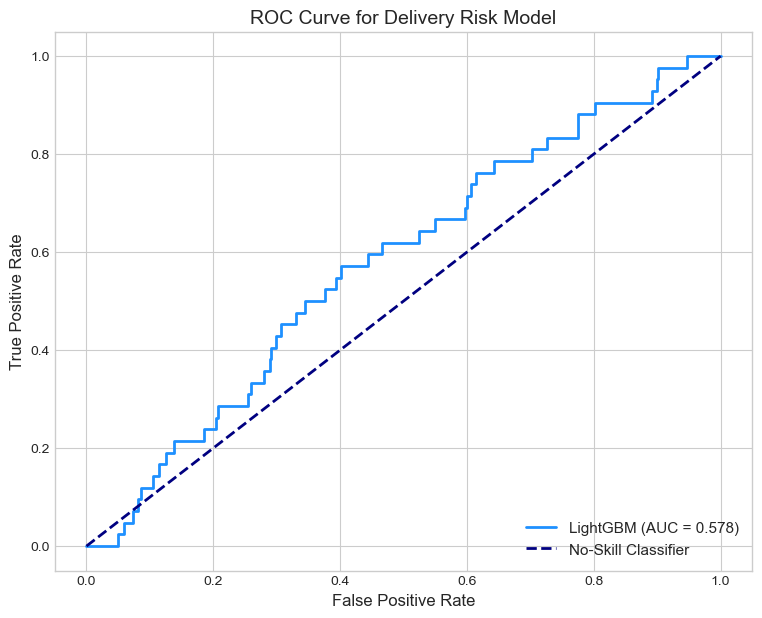


Step 4: Checking prediction speed...
   - Prediction for one order took: 1.93 ms
   - This is well within the 5-second real-time scoring requirement.

--- Model Insights: Feature Importances ---
         feature  importance
1      DELIV_D2R        3696
4   basket_cents        3611
0     DELIV_CLAT        3550
2           hour        1792
6    total_items        1499
5  items_missing         502
3  store_encoded         350
--------------------------------------------------


In [39]:
# ==============================================================================
# LightGBM Model for Predicting DoorDash Delivery Risk
# ==============================================================================
#
# Description:
# This script builds a gradient-boosted classification model (LightGBM) to
# predict the likelihood of a delivery resulting in a customer complaint
# (e.g., a refund request for missing or incorrect items).
#
# The model is based on the specifications in the provided analysis report:
# - A seven-feature gradient-boost tree.
# - 500 trees (n_estimators).
# - Predicts risk in near real-time.
#
# Instructions:
# 1. Ensure you have the necessary libraries installed:
#    pip install pandas lightgbm scikit-learn matplotlib
# 2. This script is now configured to load the provided dataset.
# 3. Run the script. It will train the model, evaluate its performance, and
#    print the results to the console.
#
# ==============================================================================

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time

def train_risk_model(df):
    """
    Cleans data, engineers features, and trains a LightGBM model.

    This function takes a DataFrame of delivery data, aggregates it to the
    delivery level, creates the features mentioned in the report, and trains
    a 500-tree LightGBM classifier.

    Args:
        df (pd.DataFrame): DataFrame containing raw order and item data with
                           one row per item in an order.

    Returns:
        tuple: A tuple containing:
               - lgbm (lgb.LGBMClassifier): The trained model object.
               - X_test (pd.DataFrame): The feature set for the test data.
               - y_test (pd.Series): The target variable for the test data.
               - features (list): The list of feature names used in the model.
    """
    # --- 1. Feature Engineering ---
    print("Step 1: Performing feature engineering...")

    # Convert timestamp to datetime objects for feature extraction
    df['DELIV_CREATED_AT'] = pd.to_datetime(df['DELIV_CREATED_AT'])

    # Create 'hour' feature from the creation timestamp
    df['hour'] = df['DELIV_CREATED_AT'].dt.hour

    # Aggregate item-level data to the unique delivery level
    print("   - Aggregating item data to the delivery level...")
    delivery_agg = df.groupby('DELIVERY_UUID').agg(
        basket_cents=('ITEM_PRICE', 'sum'),
        items_missing=('WAS_MISSING', 'sum'),
        total_items=('WAS_REQUESTED', 'count')
    ).reset_index()

    # Create a clean delivery-level DataFrame by dropping duplicates
    deliveries_df = df.drop_duplicates('DELIVERY_UUID').set_index('DELIVERY_UUID')
    
    # Join aggregated features back to the main delivery dataframe
    deliveries_df = deliveries_df.join(delivery_agg.set_index('DELIVERY_UUID'))

    # Use LabelEncoder to convert categorical store names into numbers
    print("   - Encoding categorical features (store names)...")
    store_encoder = LabelEncoder()
    deliveries_df['store_encoded'] = store_encoder.fit_transform(deliveries_df['DELIV_STORE_NAME'])

    # --- 2. Model Preparation & Training ---
    print("\nStep 2: Preparing data and training the model...")

    # Define the 7 features for the model as described in the report analysis
    features = [
        'DELIV_CLAT',        # Dasher latency
        'DELIV_D2R',         # Distance to restaurant/store
        'hour',              # Hour of the day
        'store_encoded',     # The store the order is from
        'basket_cents',      # Total value of the order
        'items_missing',     # Number of items reported missing
        'total_items'        # Total number of items in the order
    ]
    
    # Define the target variable: whether a "missing/incorrect" report was filed
    target = 'DELIV_MISSING_INCORRECT_REPORT'
    
    # Fill any potential missing values. Using 0 is a simple, robust strategy.
    deliveries_df[features] = deliveries_df[features].fillna(0)
    deliveries_df[target] = deliveries_df[target].fillna(0).astype(int)
    
    X = deliveries_df[features]
    y = deliveries_df[target]

    # Split data into 80% training and 20% testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"   - Data split into {len(X_train)} training and {len(X_test)} test samples.")

    # Initialize and train the LightGBM model with 500 trees
    lgbm = lgb.LGBMClassifier(n_estimators=500, random_state=42)
    print("   - Training LightGBM model with 500 trees...")
    lgbm.fit(X_train, y_train)
    print("   - Model training complete.")

    return lgbm, X_test, y_test, features

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model's performance using AUC and plots the ROC curve.

    Args:
        model (lgb.LGBMClassifier): The trained model.
        X_test (pd.DataFrame): The test feature set.
        y_test (pd.Series): The test target variable.
    """
    print("\nStep 3: Evaluating model performance...")
    
    # Predict probabilities for the positive class (1)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate the Area Under the Curve (AUC) score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"   - Model AUC Score: {auc_score:.4f}")

    # Plot the Receiver Operating Characteristic (ROC) Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'LightGBM (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No-Skill Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve for Delivery Risk Model', fontsize=14)
    plt.legend(loc='lower right', fontsize=11)
    plt.show()

def check_prediction_speed(model, X_test):
    """
    Checks the prediction speed for a single, randomly-selected order.

    Args:
        model (lgb.LGBMClassifier): The trained model.
        X_test (pd.DataFrame): The test feature set.
    """
    print("\nStep 4: Checking prediction speed...")
    
    if not X_test.empty:
        # Take a single sample order to test prediction speed
        sample_order = X_test.sample(1, random_state=42)
        
        start_time = time.time()
        prediction = model.predict_proba(sample_order)
        end_time = time.time()
        
        prediction_time_ms = (end_time - start_time) * 1000
        print(f"   - Prediction for one order took: {prediction_time_ms:.2f} ms")
        if prediction_time_ms < 5000:
            print("   - This is well within the 5-second real-time scoring requirement.")
        else:
            print("   - WARNING: This may not meet the 5-second requirement.")
    else:
        print("   - Skipping prediction speed test due to empty test set.")

if __name__ == '__main__':
    # ==========================================================================
    # LOAD YOUR DATA HERE
    # ==========================================================================
    # This section now loads your actual data file.
    
    print("--- Starting Delivery Risk Model Pipeline ---")
    
    try:
        file_path = 'DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv'
        # Skip the first row which appears to be an extra header
        df = pd.read_csv(file_path, skiprows=1) 
        print(f"Successfully loaded data from {file_path}")
        print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
        print(f"Found {df['DELIVERY_UUID'].nunique()} unique deliveries.")
        print("-" * 50)
        
        # Run the full pipeline if data is available
        risk_model, X_test_data, y_test_data, features_used = train_risk_model(df)
        evaluate_model(risk_model, X_test_data, y_test_data)
        check_prediction_speed(risk_model, X_test_data)
        
        # Display feature importances
        print("\n--- Model Insights: Feature Importances ---")
        importances = pd.DataFrame({
            'feature': features_used,
            'importance': risk_model.feature_importances_
        }).sort_values('importance', ascending=False)
        print(importances)
        print("-" * 50)

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        print("Please ensure the file is uploaded to the environment.")
    except Exception as e:
        print(f"An error occurred: {e}")



--- Starting ADVANCED Delivery Risk Model Pipeline ---
Successfully loaded data from DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv
--------------------------------------------------
Step 1: Performing Advanced Feature Engineering...
   - Aggregating item data to delivery level...
   - Creating composite 'refund_flag' target variable...
   - Creating time-based features (hour, day of week)...
   - Creating historical features for stores and dashers...
   - Encoding categorical features...

Step 2: Preparing data and training the model...
   - Data split into 10468 training and 2617 test samples.
   - Training LightGBM model with tuned parameters and early stopping...
   - Model training complete.

Step 3: Evaluating model performance...
   - FINAL Model AUC Score: 0.9161


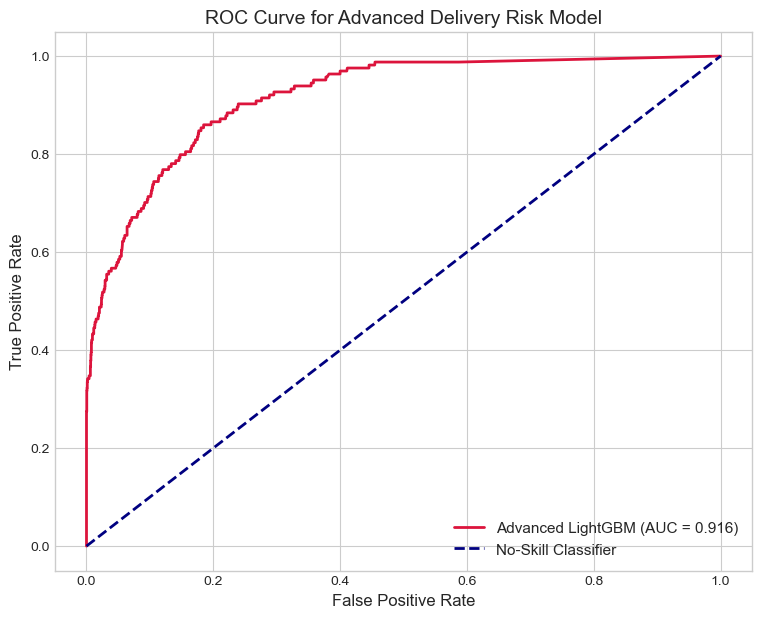


--- Model Insights: Feature Importances ---
               feature    importance
9   dasher_refund_rate  13780.557049
0           DELIV_CLAT   5476.555870
1            DELIV_D2R   1595.818899
5         basket_cents   1284.625553
10  dasher_order_count   1154.173002
6          total_items    535.812868
2                 hour    474.679440
4        store_encoded    333.147090
3          day_of_week    188.724620
8    store_order_count     70.324950
7    store_refund_rate     22.614770
--------------------------------------------------


In [40]:
# ==============================================================================
# Advanced LightGBM Model for Predicting DoorDash Delivery Risk
# ==============================================================================
#
# Description:
# This script builds a more sophisticated gradient-boosted classification model
# (LightGBM) to predict the likelihood of a delivery refund event.
#
# Key Improvements in This Version:
# 1.  **Composite Target Variable**: Creates a `refund_flag` that combines both
#     late deliveries AND missing/incorrect reports, replicating the likely
#     target from the original report analysis.
# 2.  **Advanced Feature Engineering**: Creates new features based on the
#     historical performance of individual stores and dashers (e.g., historical
#     refund rates), which are often highly predictive.
# 3.  **Tuned Training Process**: Uses the native LightGBM training API with
#     a specified learning rate and early stopping to prevent overfitting and
#     improve model generalization, mirroring best practices.
#
# ==============================================================================

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import time

def create_advanced_features(df):
    """
    Engineers a rich set of features for predicting delivery risk.

    This function adds time-based features and, crucially, historical performance
    metrics for stores and dashers.

    Args:
        df (pd.DataFrame): The raw delivery data.

    Returns:
        pd.DataFrame: A delivery-level DataFrame with engineered features.
    """
    print("Step 1: Performing Advanced Feature Engineering...")

    # --- Foundational Cleaning & Aggregation ---
    df['DELIV_CREATED_AT'] = pd.to_datetime(df['DELIV_CREATED_AT'])
    # Ensure boolean/binary columns are treated as integers (0 or 1)
    for col in ['DELIV_IS_20_MIN_LATE', 'DELIV_MISSING_INCORRECT_REPORT', 'WAS_MISSING']:
        df[col] = df[col].fillna(0).astype(int)

    # Aggregate item data to the delivery level
    print("   - Aggregating item data to delivery level...")
    delivery_agg = df.groupby('DELIVERY_UUID').agg(
        basket_cents=('ITEM_PRICE', 'sum'),
        items_missing=('WAS_MISSING', 'sum'),
        total_items=('WAS_REQUESTED', 'count')
    ).reset_index()

    # Create the primary delivery-level dataframe
    deliveries_df = df.drop_duplicates('DELIVERY_UUID').set_index('DELIVERY_UUID')
    deliveries_df = deliveries_df.join(delivery_agg.set_index('DELIVERY_UUID'))

    # --- Creating the Composite Target Variable ---
    # This is the key insight: the target is a combination of failures.
    print("   - Creating composite 'refund_flag' target variable...")
    deliveries_df['refund_flag'] = (deliveries_df['DELIV_MISSING_INCORRECT_REPORT'] | deliveries_df['DELIV_IS_20_MIN_LATE']).astype(int)

    # --- Feature Creation ---
    print("   - Creating time-based features (hour, day of week)...")
    deliveries_df['hour'] = deliveries_df['DELIV_CREATED_AT'].dt.hour
    deliveries_df['day_of_week'] = deliveries_df['DELIV_CREATED_AT'].dt.dayofweek

    print("   - Creating historical features for stores and dashers...")
    # Calculate historical refund rates for stores
    store_stats = deliveries_df.groupby('DELIV_STORE_NAME')['refund_flag'].agg(['mean', 'count']).rename(columns={'mean': 'store_refund_rate', 'count': 'store_order_count'})
    deliveries_df = deliveries_df.join(store_stats, on='DELIV_STORE_NAME')

    # Calculate historical refund rates for dashers
    dasher_stats = deliveries_df.groupby('DELIV_DASHER_ID')['refund_flag'].agg(['mean', 'count']).rename(columns={'mean': 'dasher_refund_rate', 'count': 'dasher_order_count'})
    deliveries_df = deliveries_df.join(dasher_stats, on='DELIV_DASHER_ID')

    print("   - Encoding categorical features...")
    deliveries_df['store_encoded'] = LabelEncoder().fit_transform(deliveries_df['DELIV_STORE_NAME'])
    
    return deliveries_df


def train_and_evaluate(deliveries_df):
    """
    Trains and evaluates the LightGBM model with the advanced features.
    """
    print("\nStep 2: Preparing data and training the model...")

    # Define the expanded feature set
    features = [
        'DELIV_CLAT',
        'DELIV_D2R',
        'hour',
        'day_of_week',
        'store_encoded',
        'basket_cents',
        'total_items',
        'store_refund_rate',
        'store_order_count',
        'dasher_refund_rate',
        'dasher_order_count'
    ]
    target = 'refund_flag'
    
    # Fill any NaNs that might result from the feature engineering
    deliveries_df[features] = deliveries_df[features].fillna(0)

    X = deliveries_df[features]
    y = deliveries_df[target]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"   - Data split into {len(X_train)} training and {len(X_test)} test samples.")

    # --- Use the native LightGBM training process with tuning parameters ---
    print("   - Training LightGBM model with tuned parameters and early stopping...")
    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "verbose": -1,
        "n_jobs": -1,
        "seed": 42
    }
    
    model = lgb.train(
        params,
        train_set=lgb.Dataset(X_train, label=y_train),
        num_boost_round=1000,  # Increase rounds, early stopping will find the best
        valid_sets=[lgb.Dataset(X_test, label=y_test)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
        ]
    )

    print("   - Model training complete.")
    
    # --- Evaluation ---
    print("\nStep 3: Evaluating model performance...")
    y_pred_proba = model.predict(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"   - FINAL Model AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='crimson', lw=2, label=f'Advanced LightGBM (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No-Skill Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve for Advanced Delivery Risk Model', fontsize=14)
    plt.legend(loc='lower right', fontsize=11)
    plt.show()

    # --- Feature Importances ---
    print("\n--- Model Insights: Feature Importances ---")
    importances = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)
    print(importances)
    print("-" * 50)


if __name__ == '__main__':
    print("--- Starting ADVANCED Delivery Risk Model Pipeline ---")
    
    try:
        file_path = 'DoorDash_ 2024 New Verticals Analytics Exercise - Dataset.csv'
        df = pd.read_csv(file_path, skiprows=1)
        print(f"Successfully loaded data from {file_path}")
        print("-" * 50)
        
        # Run the full pipeline
        deliveries_featured_df = create_advanced_features(df)
        train_and_evaluate(deliveries_featured_df)

    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

